In [1]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib


In [2]:
channels=3
data = pathlib.Path('/Users/tejasbk/Documents/code/plantDiseaseDetection/plantDiseaseDetection/content')
trainSize = 0.7
validationSize = 0.15
testSize = 0.15
imgSize = 256
classes = 6
EPOCHS=25
batchSize=32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    shuffle=True,
    image_size=(imgSize,imgSize),
    batch_size=batchSize
)

Found 14348 files belonging to 6 classes.


In [4]:
classnames=dataset.class_names
print(classnames)

['Apple_Healthy', 'Apple_Unhealthy', 'Strawberry_Healthy', 'Strawberry_Unhealthy', 'Tomato_Healthy', 'Tomato_Unhealthy']


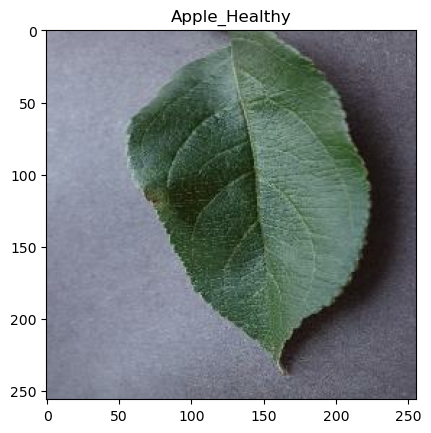

In [5]:
for i,l in dataset.take(1):

  plt.imshow(i[2].numpy().astype("uint8"))
  plt.title(classnames[l[2]])



In [6]:
def partition_size(ds,trainSize,validationSize,testSize,shuffle=True,shuffle_size=10000):
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=10)
  train_ds = ds.take(int(trainSize*len(ds)))
  test_ds = ds.skip(len(train_ds))
  validation_ds = ds.take(int(validationSize*len(ds)))
  test_ds = test_ds.skip(len(validation_ds))
  return train_ds,validation_ds,test_ds

In [7]:
train_ds,validation_ds,test_ds=partition_size(dataset,trainSize,validationSize,testSize,shuffle=True,shuffle_size=10000)
print(len(train_ds),len(validation_ds),len(test_ds))

314 67 68


In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds=validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgSize,imgSize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.5)
])

In [10]:
model = models.Sequential([
    resize_rescale,
    augmentation,
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(512,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(classes,activation='softmax')
])
model.build(input_shape = (batchSize,imgSize,imgSize,channels))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics='accuracy'
    )

In [13]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=validation_ds
    )

Epoch 1/50
314/314 [==============================] - 232s 724ms/step - loss: 1.1019 - accuracy: 0.5418 - val_loss: 0.7322 - val_accuracy: 0.6875
Epoch 2/50
314/314 [==============================] - 220s 700ms/step - loss: 0.5577 - accuracy: 0.7944 - val_loss: 0.5066 - val_accuracy: 0.8195
Epoch 3/50
314/314 [==============================] - 219s 698ms/step - loss: 0.3146 - accuracy: 0.8879 - val_loss: 0.5332 - val_accuracy: 0.8694
Epoch 4/50
314/314 [==============================] - 220s 700ms/step - loss: 0.2181 - accuracy: 0.9253 - val_loss: 0.3445 - val_accuracy: 0.8913
Epoch 5/50
314/314 [==============================] - 220s 700ms/step - loss: 0.1805 - accuracy: 0.9386 - val_loss: 0.3763 - val_accuracy: 0.9025
Epoch 6/50
314/314 [==============================] - 219s 699ms/step - loss: 0.1528 - accuracy: 0.9479 - val_loss: 0.4424 - val_accuracy: 0.8904
Epoch 7/50
314/314 [==============================] - 219s 699ms/step - loss: 0.1163 - accuracy: 0.9594 - val_loss: 0.4107 -

In [14]:
model.evaluate(test_ds)

68/68 [==============================] - 18s 188ms/step - loss: 0.0061 - accuracy: 0.9977


[0.006137210875749588, 0.9977021813392639]

Actual prediction -  Strawberry_Unhealthy
1/1 [==============================] - 0s 189ms/step
model prediction -  Strawberry_Unhealthy


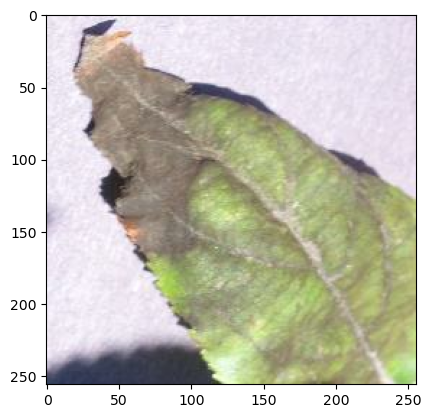

In [39]:
for i,l in dataset.take(1):
  img=i[1].numpy().astype('uint8')
  label=l[0].numpy()
#   print(i)
  plt.imshow(img)
  print("Actual prediction - ", classnames[label])
  batch_pred=model.predict(i)
  print("model prediction - ",classnames[np.argmax(batch_pred[0])])

In [16]:
def predict(model,image):
  imgArr=tf.keras.preprocessing.image.img_to_array(i[j].numpy())
  imgArr=tf.expand_dims(imgArr,0)

  predictions=model.predict(imgArr)
  predictedClass=classnames[np.argmax(predictions[0])]
  confidence=round(100*(np.max(batch_pred[0])),2)
  return predictedClass, confidence

1/1 [==============================] - 0s 17ms/step


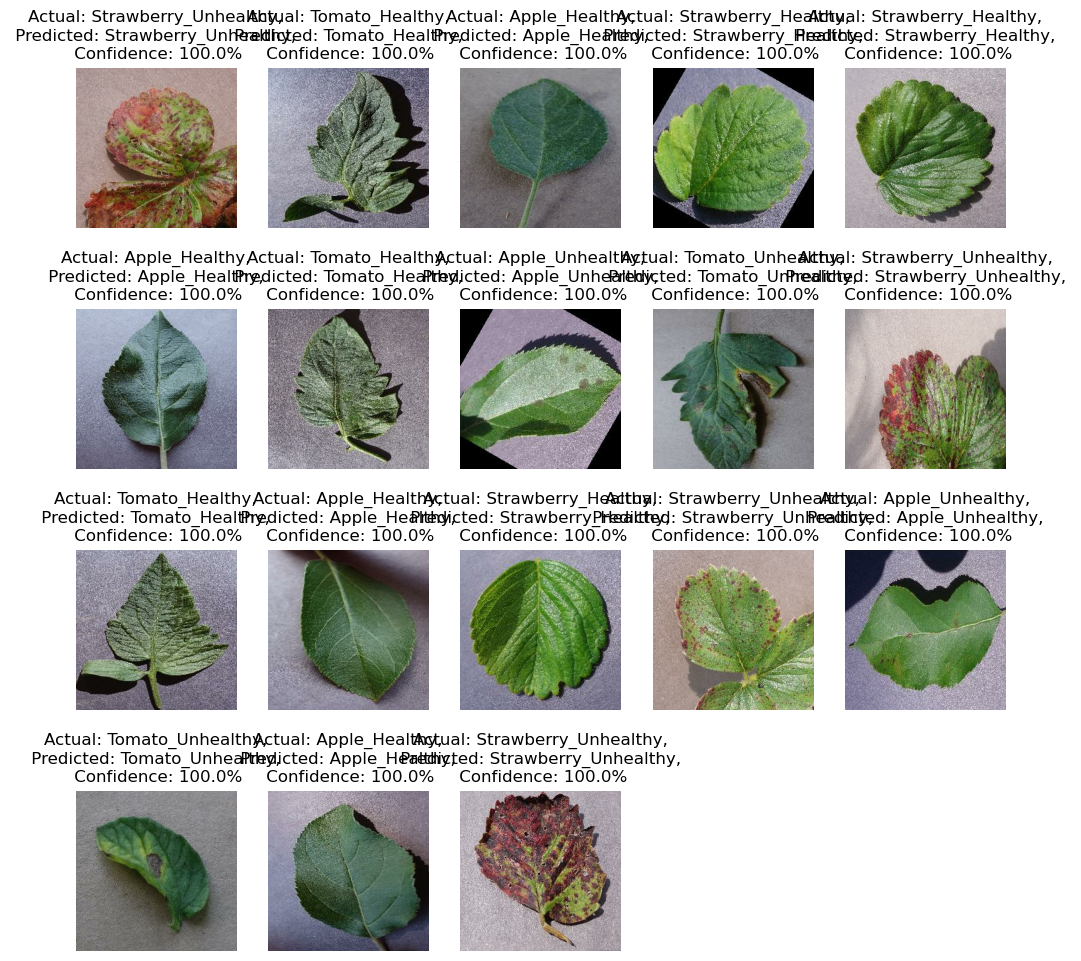

In [18]:
plt.figure(figsize=(12,12))
for i,l in dataset.take(1):
  for j in range(18):
    ax=plt.subplot(4,5,j+1)
    plt.imshow(i[j].numpy().astype('uint8'))
    predictedClass,confidence = predict(model, i[j].numpy())
    actual=classnames[l[j]]
    plt.title(f"Actual: {actual},\n Predicted: {predictedClass}, \n Confidence: {confidence}%")
    plt.axis("off")

In [20]:
model_version=3
model.save("model.h5")

In [5]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import cv2
model = load_model('/Users/tejasbk/Documents/code/plantDiseaseDetection/plantDiseaseDetection/model.h5')


In [7]:
img = image.load_img('/Users/tejasbk/Documents/code/plantDiseaseDetection/Test/test.jpg', target_size=(256, 256))
name = img.filename
img = np.array(img)

x = np.expand_dims(img, axis=0)

In [8]:
output = model.predict(x)
# output = output.astype(int).sum(axis=1) - 1
print(classnames[np.argmax(output[0])])
plt.imshow(img)
print(name)

1/1 [==============================] - 0s 61ms/step


NameError: name 'classnames' is not defined

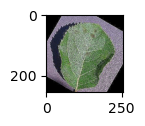

In [17]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib



kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
img1 = np.array(img)
image_sharp = cv2.filter2D(src=img1, ddepth=-1, kernel=kernel)
plt.figure(figsize=(1,1))
# plt.imshow(img1)
plt.imshow(image_sharp)